In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [15]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 512
n_iter = 1000
BATCHSZ = 64*2

In [11]:
#visdom client
vis = visdom.Visdom(port=7777)

In [3]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, e_out_dim) #for mu and sigma 
		self.L3 = tchnn.Linear(e_out_dim, e_out_dim)#for mu
		self.L4 = tchnn.Linear(e_out_dim, e_out_dim)#for sigma
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.relu(self.Ou(x))
		#mu = x[:, :e_out_dim]
		#sig = x[:, e_out_dim:]
		mu = self.L3(x)
		sig = self.L4(x)
		#need to make sure that sigmas are positive
		#sig = F.softplus(sig)
		return mu, sig
		
	def name(self):
		return 'Encoder'

In [4]:
class Decoder(tchnn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, d_out_dim)
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.sigmoid(self.Ou(x))
		return x
	
	def name(self):
		return 'Decoder'

In [5]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        m.bias.data.fill_(0) #make it all zero, see the scripts

In [6]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [7]:
#data loading and related stuff
MNISTX_train = np.load('../../gmmGAN/MNISTX_train.npy')
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [8]:
print(next(MNISTd)[0,:])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [9]:
#mnist batch plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

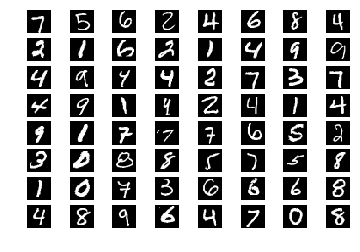

In [10]:
plotter(next(MNISTd)[0:64])

In [23]:
d = next(MNISTd)
d = d.reshape(-1,1,28,28)
# print(d.shape)
vis.images(d[0:45,:,:,:],
          opts=dict(title='Random!', caption='How random.'),)

'window_35ca4b20712fdc'

In [11]:
#pretraining
E = Encoder().cuda()
D = Decoder().cuda()
E = E.double()
D = D.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder (
  (L1): Linear (784 -> 512)
  (Ou): Linear (512 -> 100)
  (L3): Linear (100 -> 100)
  (L4): Linear (100 -> 100)
)
Decoder (
  (L1): Linear (100 -> 512)
  (Ou): Linear (512 -> 784)
)


In [42]:
list(E.parameters())+ list(D.parameters())

[Parameter containing:
 -1.7827e-02 -1.7806e-02 -5.9077e-03  ...  -2.1912e-02 -5.8538e-03 -1.0049e-02
 -2.1709e-02  4.7425e-02 -9.5942e-04  ...   9.5575e-03  1.2265e-02 -1.1661e-02
 -1.8080e-02  3.8126e-03 -1.7482e-03  ...  -2.3244e-03  1.3635e-02  6.2563e-02
                 ...                   ⋱                   ...                
 -3.3585e-03  1.3208e-02  1.7590e-02  ...  -1.6484e-03  1.8603e-02  7.8758e-03
  3.8834e-02 -5.0585e-02  8.1510e-03  ...   1.9907e-02  1.9622e-02 -1.3050e-02
  1.4259e-02 -4.8798e-03  1.1959e-02  ...  -1.4296e-02 -1.0562e-02  1.6351e-03
 [torch.cuda.DoubleTensor of size 1000x784 (GPU 0)], Parameter containing:
  0
  0
  0
 ⋮ 
  0
  0
  0
 [torch.cuda.DoubleTensor of size 1000 (GPU 0)], Parameter containing:
  1.0972e-02  2.2923e-02 -1.1466e-02  ...  -1.0621e-02  2.3385e-02 -3.1726e-02
 -4.1588e-02 -9.0409e-03  8.5964e-03  ...  -1.8006e-02 -1.6048e-02  2.9407e-02
  1.6162e-02  1.8110e-02  1.6426e-03  ...   2.0850e-02  1.3581e-02  1.2376e-02
             

In [12]:
optim = tchoptim.Adam(list(E.parameters())+ list(D.parameters()), lr=1e-3)

In [13]:
def sample_z(mu, sig):
    e = Variable(tch.randn(BATCHSZ, e_out_dim).cuda().double())
    r = mu + (e*tch.exp(sig/2))
    return r
    

randomly chosen 64 generated samples after itr: 0


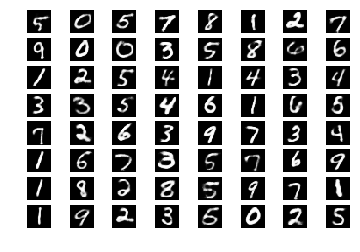

randomly chosen 64 generated samples after itr: 100


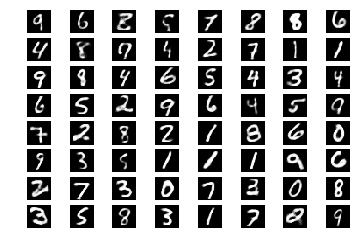

randomly chosen 64 generated samples after itr: 200


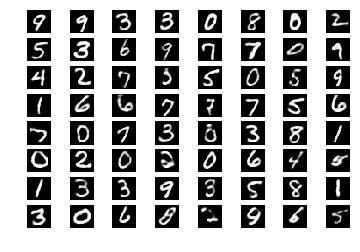

randomly chosen 64 generated samples after itr: 300


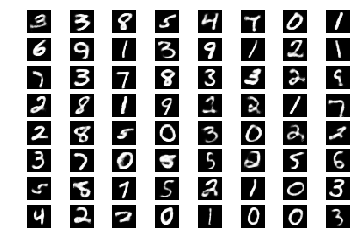

randomly chosen 64 generated samples after itr: 400


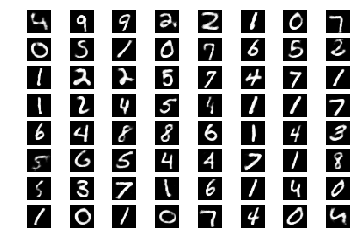

randomly chosen 64 generated samples after itr: 500


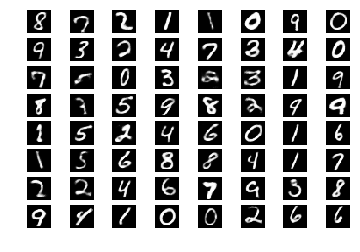

randomly chosen 64 generated samples after itr: 600


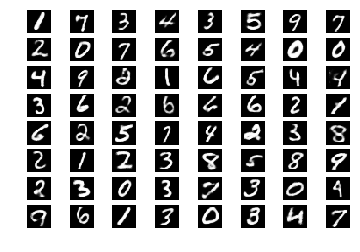

randomly chosen 64 generated samples after itr: 700


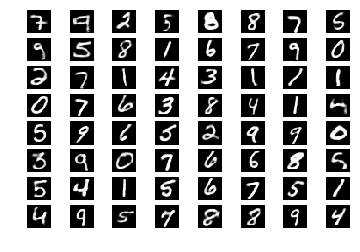

randomly chosen 64 generated samples after itr: 800


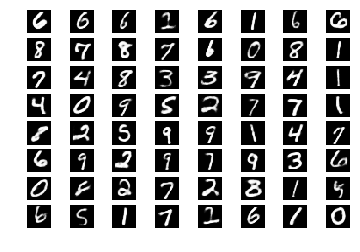

randomly chosen 64 generated samples after itr: 900


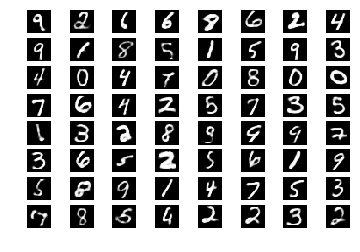

In [16]:
#training
for itr in range(n_iter):
    X = next(MNISTd)
    X = Variable(tch.from_numpy(X).cuda())
    #through the encoder
    E.zero_grad()
    z_mu, z_log_sig = E(X)
    z = sample_z(z_mu, z_log_sig)
    
    #through the decoder
    z = z.cuda()
    D.zero_grad()
    d_out = D(z)
    #loss
    recon_loss = F.binary_cross_entropy(d_out, X)
    KL_div = tch.mean(0.5 * tch.sum(tch.exp(z_log_sig) + z_mu**2 - 1. - z_log_sig, 1))
    KL_div /= BATCHSZ*28*28 # <- learnt a lesson, constansdo matter, kind of like units
    loss = recon_loss + KL_div
    
    loss.backward()
    optim.step()
    
    #print results sometimes
    if itr%100 == 0:
        #print('64 generated samples after itr: {}'.format(itr))
        print('randomly chosen 64 generated samples after itr: {}'.format(itr))
        d = d_out.data.cpu().numpy()[0:64,:]
        d = d.reshape(-1,1,28,28)
        d1 = list(d)
        d1 = random.sample(d1, 64)
        d = np.array(d1)
        plotter(d) 

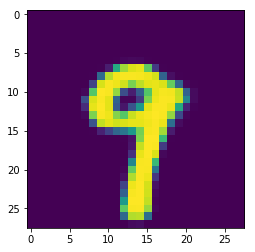

In [37]:
z_test = tch.randn(1,d_inp_dim)*4+1
z_test = z_test.view(-1, d_inp_dim)
y = D(z)
y1 = y.data.cpu().numpy().reshape(-1,28,28)
plt.imshow(y1[7,:,:])
plt.show()